In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Data Set.xlsx to Data Set.xlsx


In [ ]:
# reading the data from the file
import io
cc = pd.read_excel(io.BytesIO(uploaded['Data Set.xlsx']))

In [ ]:
cc = pd.read_excel('Data Set.xlsx')

In [ ]:
# We will let the categorical data remain in as integer data type for ML libraries do not take categorical variables as input.
cc.info(max_cols=131)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 130 columns):
custid               5000 non-null object
region               5000 non-null int64
townsize             4998 non-null float64
gender               5000 non-null int64
age                  5000 non-null int64
agecat               5000 non-null int64
birthmonth           5000 non-null object
ed                   5000 non-null int64
edcat                5000 non-null int64
jobcat               5000 non-null int64
union                5000 non-null int64
employ               5000 non-null int64
empcat               5000 non-null int64
retire               5000 non-null int64
income               5000 non-null int64
lninc                5000 non-null float64
inccat               5000 non-null int64
debtinc              5000 non-null float64
creddebt             5000 non-null float64
lncreddebt           4999 non-null float64
othdebt              5000 non-null float64
lnothdebt        

In [ ]:
# Removing duplicate features such as log variables and categorical features having numerical features, and having no buisness significance
# Removing commutecar, caommutewalk etc. all the dummy variables for the commute (we will creat our own dummies as and when required)
cc.drop(['custid','birthmonth','lnwireten','lnwiremon','lntollten','lntollmon','lnothdebt','lnlongten',
         'lnlongmon','lninc','lnequipten','lnequipmon','lncreddebt','lncardten','lncardmon','agecat','edcat',
         'empcat','inccat','spousedcat','addresscat','commutecar','commutemotorcycle','commutecarpool','commutebus',
         'commuterail','commutepublic','commutebike','commutewalk','commutenonmotor','telecommute','cardtenurecat',
        'card2tenurecat','carcatvalue'], axis=1, inplace=True)


In [ ]:
# Creating total spend
cc['Total_spend'] = cc.cardspent + cc.card2spent
cc.drop(['cardspent','card2spent'], axis=1, inplace=True)

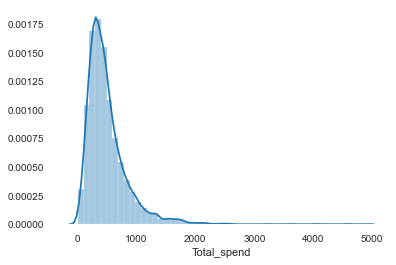

In [ ]:
# Distribution of target variable
sns.distplot(cc.Total_spend)
# It shows that it is having some skewnwess, implies we have to apply some transformations(log, box-cox, etc.)

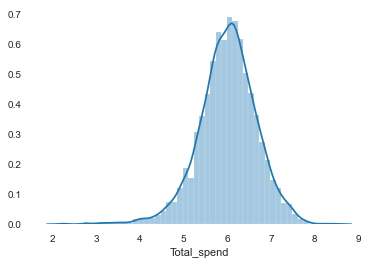

In [ ]:
sns.distplot(np.log(cc.Total_spend + 1))
# We can see that it is very close to a normal distribution

In [ ]:
cc['ln_total_spend'] = np.log(cc.Total_spend + 1)
cc.drop(['Total_spend'], axis=1, inplace=True)

### Missing value treatment

In [ ]:
#carbought, carcatvalue, carvalue, cartype, carown, spoused has -1 for the missing values
# Replacing -1 with mode value
for x in ['carbought','carown','cartype','townsize']:
    cc[x] = np.where(cc[x]==-1, cc[x].mode(), cc[x])

In [ ]:
#imputing carvalue and townsize with mean
cc.cardten.fillna(cc.cardten.mean(), inplace=True)
cc.longten.fillna(cc.longten.mean(), inplace=True)
cc.carvalue = np.where(cc.carvalue==-1, cc.carvalue.mean(), cc.carvalue)

In [ ]:
credit_card_cat = ['region','townsize','gender','jobcat','union','retire','default','jobsat',
                  'marital','homeown','hometype','carown','cartype','carbought',
                  'carbuy','commutecat','reason','polview','polparty',
                  'polcontrib','vote','card','cardtype','cardbenefit','cardfee','card2','card2type',
                  'card2benefit','card2fee','active','bfast','churn','tollfree','equip','callcard',
                  'wireless','multline','voice','pager','internet','callid','callwait','forward','confer','ebill','owntv',
                  'ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02',
                  'response_03','pets_birds','pets_cats','pets_dogs','pets_freshfish','pets_reptiles',
                  'pets_saltfish','pets_small','commutecar','commutemotorcycle','commutecarpool','commutebus',
         'commuterail','commutepublic','commutebike','commutewalk','commutenonmotor','telecommute']

In [ ]:
annova=pd.DataFrame()
for x in credit_card_cat:
    if cc[x].nunique()==5:
        F,y = stats.f_oneway(cc[cc[x]==cc[x].unique()[0]].ln_total_spend, cc[cc[x]==cc[x].unique()[1]].ln_total_spend,
                                  cc[cc[x]==cc[x].unique()[2]].ln_total_spend,cc[cc[x]==cc[x].unique()[3]].ln_total_spend,
                                  cc[cc[x]==cc[x].unique()[4]].ln_total_spend)
    if cc[x].nunique()==6:
        F,y = stats.f_oneway(cc[cc[x]==cc[x].unique()[0]].ln_total_spend, cc[cc[x]==cc[x].unique()[1]].ln_total_spend,
                                  cc[cc[x]==cc[x].unique()[2]].ln_total_spend,cc[cc[x]==cc[x].unique()[3]].ln_total_spend,
                                  cc[cc[x]==cc[x].unique()[4]].ln_total_spend, cc[cc[x]==cc[x].unique()[5]].ln_total_spend)
    if cc[x].nunique()==3:
        F,y = stats.f_oneway(cc[cc[x]==cc[x].unique()[0]].ln_total_spend, cc[cc[x]==cc[x].unique()[1]].ln_total_spend,
                                  cc[cc[x]==cc[x].unique()[2]].ln_total_spend)
    if cc[x].nunique()==4:
        F,y = stats.f_oneway(cc[cc[x]==cc[x].unique()[0]].ln_total_spend, cc[cc[x]==cc[x].unique()[1]].ln_total_spend,
                                  cc[cc[x]==cc[x].unique()[2]].ln_total_spend,cc[cc[x]==cc[x].unique()[3]].ln_total_spend)
    if cc[x].nunique()==2:
        F,y = stats.f_oneway(cc[cc[x]==cc[x].unique()[0]].ln_total_spend, cc[cc[x]==cc[x].unique()[1]].ln_total_spend)
    if cc[x].nunique()==10:
         F,y = stats.f_oneway(cc[cc[x]==cc[x].unique()[0]].ln_total_spend, cc[cc[x]==cc[x].unique()[1]].ln_total_spend,
                              cc[cc[x]==cc[x].unique()[2]].ln_total_spend,cc[cc[x]==cc[x].unique()[3]].ln_total_spend,
                              cc[cc[x]==cc[x].unique()[4]].ln_total_spend, cc[cc[x]==cc[x].unique()[5]].ln_total_spend,
                             cc[cc[x]==cc[x].unique()[6]].ln_total_spend,cc[cc[x]==cc[x].unique()[6]].ln_total_spend,
                              cc[cc[x]==cc[x].unique()[8]].ln_total_spend,cc[cc[x]==cc[x].unique()[9]].ln_total_spend)
        
    d = pd.DataFrame({'Feature': [x] , 'F_value': [F],'P_value':[y] })
    annova=annova.append(d)

In [ ]:
len(credit_card_cat)

75

In [ ]:
annova.to_csv('annova2.csv')

In [ ]:
credit_card_cat_fin = ['card','retire','card2','owndvd','carown','ownvcr','reason','polview','owncd','owntv','gender',
                       'wireless','jobcat','ownpda','homeown','internet','ownfax','response_03','pager','vote','hometype',
                       'confer','callwait','callid','tollfree','jobsat','equip','forward','voice','multline','ownpc',
                       'ownipod','owngame','bfast','ebill','polcontrib']

In [ ]:
credit_card_num = cc.columns.difference(credit_card_cat)

### Outlier treatment 

In [ ]:
cc[credit_card_num] = cc[credit_card_num].apply(lambda x: x.clip(lower = x.quantile(0.01), 
                                                         upper = x.quantile(0.99)))

In [ ]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.nunique(), x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['C', 'N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [ ]:
cc[credit_card_cat_fin].apply(categorical_var_summary).T

,C,N,NMISS,MODE,FREQ,PERCENT
card,5.0,5000.0,0.0,4.0,1344.0,26.88
retire,2.0,5000.0,0.0,0.0,4262.0,85.24
card2,5.0,5000.0,0.0,3.0,1384.0,27.68
owndvd,2.0,5000.0,0.0,1.0,4568.0,91.36
carown,2.0,5000.0,0.0,1.0,4201.0,84.02
ownvcr,2.0,5000.0,0.0,1.0,4578.0,91.56
reason,5.0,5000.0,0.0,9.0,4052.0,81.04
polview,7.0,5000.0,0.0,4.0,1733.0,34.66
owncd,2.0,5000.0,0.0,1.0,4664.0,93.28
owntv,2.0,5000.0,0.0,1.0,4915.0,98.30


In [ ]:
def continuous_var_summary(x):
    return pd.Series([x.dtype, x.nunique(), x.count(), x.isnull().sum(), x.sum(), x.mean(),
                      x.median(), x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
            index = ['DataType', 'C', 'N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 
                           'P1', 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [ ]:
cc[credit_card_num].apply(continuous_var_summary).T

,DataType,C,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
address,int64,49,5000,0,81832,16.3664,14,12.2979,151.238,0,0,1,2,6,14,25,34,40,48,48
age,int64,62,5000,0,235128,47.0256,47,17.7703,315.785,18,18,20,23,31,47,62,72,76,79,79
card2tenure,int64,31,5000,0,65422,13.0844,12,9.1194,83.1635,0,0,1,2,5,12,21,27,29,30,30
cardmon,float64,229,5000,0,76334.8,15.2669,13.75,14.1563,200.402,0,0,0,0,0,13.75,22.75,34,42,64.25,64.25
cardten,float64,651,5000,0,3.53618e+06,707.236,425,848.139,719340,0,0,0,0,0,425,1080,1870.5,2455.25,4010,4010.4
cardtenure,int64,41,5000,0,83279,16.6558,14,12.021,144.503,0,0,1,2,6,14,26,35,38,40,40
cars,int64,7,5000,0,10638,2.1276,2,1.29725,1.68285,0,0,0,1,1,2,3,4,4,6,6
carvalue,float64,750,5000,0,128090,25.6179,21.1,19.5481,382.127,4.2,4.2,5.895,7.6,12.1,21.1,31.1,52.91,72,92,92.001
commute,int64,10,5000,0,14981,2.9962,1,2.74352,7.52689,1,1,1,1,1,1,4,8,8,10,10
commutetime,float64,29,4998,2,126610,25.3322,25,5.75586,33.13,13,13,16,18,21,25,29,33,35,40.0009,40.03


### Correlation b/w numerical features

In [ ]:
def linear_relationship(x, y):
    cor_x = np.corrcoef(y, x)[1][[0]][0]
    cor_log_x = np.corrcoef(y, np.log(x+1))[1][[0]][0]
    cor_exp_x =  np.corrcoef(y, np.exp(x))[1][[0]][0]
    cor_sqrt_x =  np.corrcoef(y,np.sqrt(x))[1][[0]][0]
    cor_sqre_x =  np.corrcoef(y,x*x)[1][[0]][0]
    return pd.Series([cor_x, cor_log_x, cor_exp_x, cor_sqrt_x, cor_sqre_x], index = ['corr_x', 'corr_logx', 'corr_expx', 'corr_sqrtx', 'corr_sqrex'])

In [ ]:
linear_relationship = cc[credit_card_num].apply(lambda x: linear_relationship(x,cc.ln_total_spend))
linear_relationship.to_csv('linear_relationship.csv')

c:\users\hp\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\hp\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\function_base.py:2445: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\users\hp\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\hp\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# card2tenure is highly correlated with cardtenure and tenure
cc.drop(['age','pets','commute','reside'], axis=1, inplace=True)

In [ ]:
cc['ln_address'] = np.log(cc.address + 1)
cc['ln_card2tenure'] = np.log(cc.card2tenure + 1)
cc['ln_cardmon'] = np.log(cc.cardmon + 1)
cc['ln_cardtenure'] = np.log(cc.cardtenure + 1)
cc['ln_creddebt'] = np.log(cc.creddebt + 1)
cc['ln_employ'] = np.log(cc.employ + 1)
cc['ln_hourstv'] = np.log(cc.hourstv + 1)
cc['ln_income'] = np.log(cc.income + 1)
cc['ln_longmon'] = np.log(cc.longmon + 1)
cc['ln_longten'] = np.log(cc.longten + 1)
cc['ln_othdebt'] = np.log(cc.othdebt + 1)
cc['ln_tenure'] = np.log(cc.tenure + 1)
cc['ln_tollten'] = np.log(cc.tollten + 1)
cc['ln_wiremon'] = np.log(cc.wiremon + 1)
cc['ln_wireten'] = np.log(cc.wireten + 1)

In [ ]:
cc.drop(['address','card2tenure','cardmon','cardtenure','creddebt','employ','hourstv','income','longmon','longten',
        'othdebt','tenure','tollten','wiremon','wireten'],axis=1, inplace=True)

In [ ]:
cc['sqrt_cardten'] = np.sqrt(cc.cardten)
cc['sqrt_carvalue'] = np.sqrt(cc.carvalue)
cc['sq_cars'] = cc.cars * cc.cars
cc['sq_debtinc'] = cc.debtinc * cc.debtinc
cc['sq_equipmon'] = cc.equipmon * cc.equipmon
cc['sq_equipten'] = cc.equipten * cc.equipten
cc['sq_spoused'] = cc.spoused * cc.spoused
cc['sq_tollmon'] = cc.tollmon * cc.tollmon

In [ ]:
cc.drop(['cardten','carvalue','cars','debtinc','equipmon','equipten','spoused','tollmon'],axis=1, inplace=True)

In [ ]:
credit_card_num = cc.columns.difference(credit_card_cat)

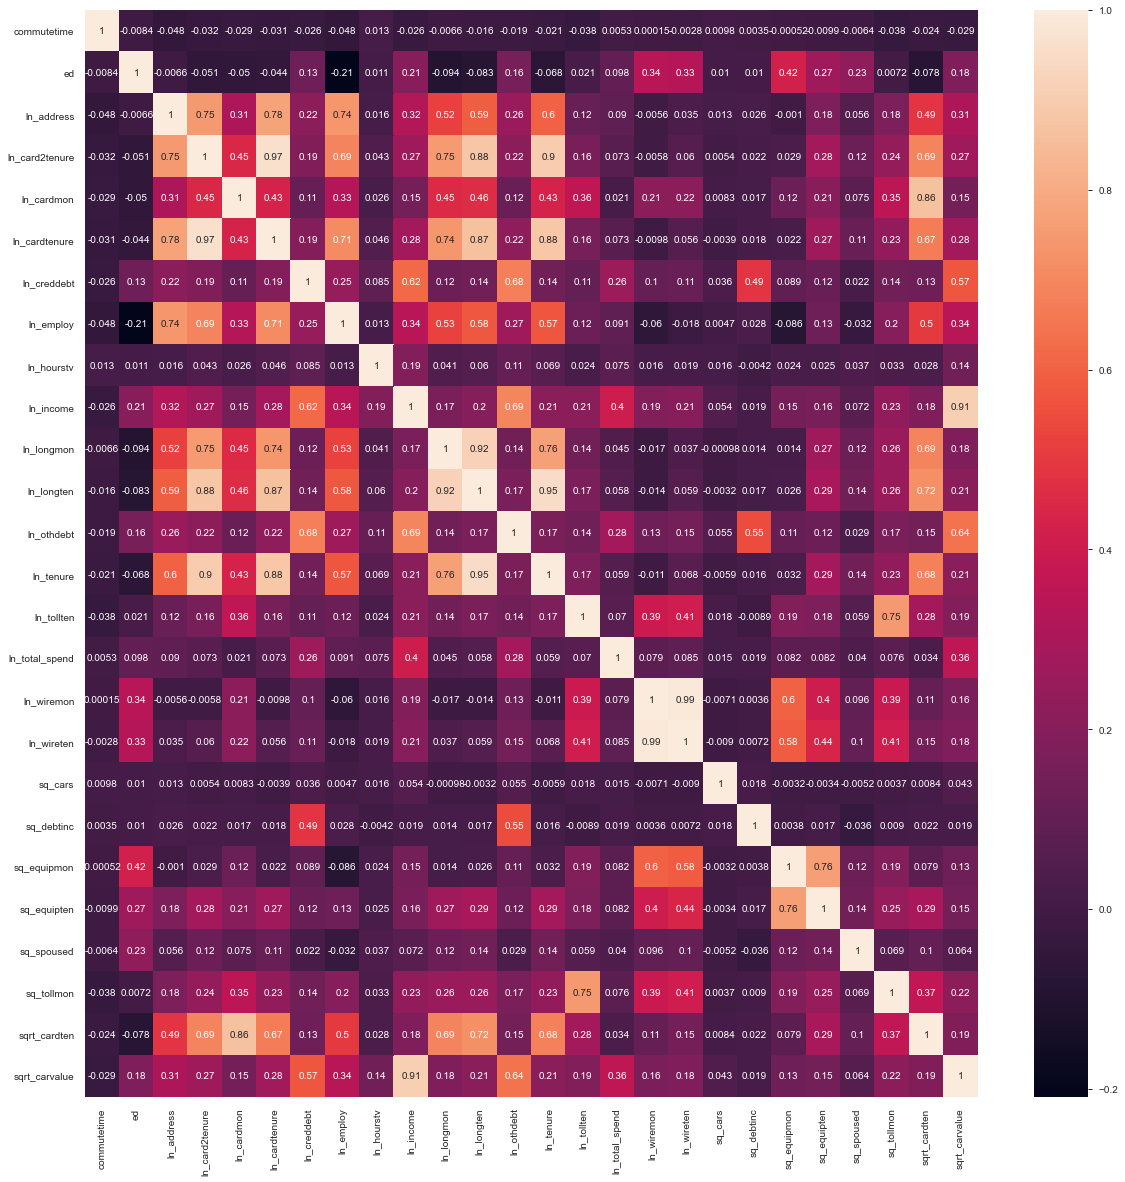

In [ ]:
y_corr = pd.DataFrame(cc[credit_card_num].corr())
plt.figure(figsize=(20,20))
sns.heatmap(y_corr, annot=True)

In [ ]:
# Dropping variables which have very less relationship with our target variable
y_corr.loc[(y_corr.ln_total_spend > -0.01) & (y_corr.ln_total_spend < 0.01)].index

Index(['commutetime'], dtype='object')

In [ ]:
cc.drop(['ln_wireten','ln_longten','ln_card2tenure','sqrt_carvalue','ln_cardtenure','ln_cardtenure'],axis=1, inplace=True)

In [ ]:
cc.drop(['commutetime'],axis=1, inplace=True)

In [ ]:
num_features = cc.columns.difference(credit_card_cat)
num_features = num_features.difference(['ln_total_spend'])

In [ ]:
cc[num_features]

,ed,ln_address,ln_cardmon,ln_creddebt,ln_employ,ln_hourstv,ln_income,ln_longmon,ln_othdebt,ln_tenure,ln_tollten,ln_wiremon,sq_cars,sq_debtinc,sq_equipmon,sq_equipten,sq_spoused,sq_tollmon,sqrt_cardten
0,15,0.000000,2.724580,0.788870,0.000000,2.639057,3.465736,2.014903,1.175601,1.791759,5.087905,0.000000,4,123.21,870.2500,1.590121e+04,1,841.00,7.745967
1,17,1.098612,2.833213,0.798417,0.000000,2.944439,2.772589,2.292535,0.943120,3.688879,0.000000,3.842673,4,345.96,3008.5225,3.900625e+06,1,0.00,24.698178
2,14,3.433987,3.178054,0.656805,2.833213,3.091042,3.583519,3.380995,1.263104,4.189655,0.000000,0.000000,9,98.01,0.0000,0.000000e+00,169,0.00,37.549967
3,16,1.386294,3.091042,0.032622,0.000000,3.295837,3.044522,1.945910,0.750094,3.610918,0.000000,0.000000,9,32.49,0.0000,0.000000e+00,324,0.00,26.172505
4,16,1.386294,2.904165,0.194463,0.693147,3.332205,3.178054,1.398717,0.162409,3.091042,5.962808,2.998229,1,2.89,0.0000,0.000000e+00,169,272.25,18.973666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10,3.218876,3.124565,2.189873,3.218876,2.995732,5.283204,3.558201,2.168587,4.248495,0.000000,0.000000,1,64.00,0.0000,0.000000e+00,1,0.00,39.560081
4996,14,2.564949,3.305054,1.467091,1.945910,2.708050,4.430817,2.433613,2.313861,3.433987,7.054622,3.363842,4,225.00,0.0000,0.000000e+00,1,1332.25,28.284271
4997,17,3.891820,2.788093,1.516779,3.218876,2.833213,4.691348,3.414443,2.208986,4.290459,8.108774,0.000000,9,116.64,0.0000,0.000000e+00,1,1936.00,32.710854
4998,19,2.833213,2.351375,1.795312,1.386294,3.218876,5.247024,2.191654,2.796711,3.637586,0.000000,0.000000,4,116.64,873.2025,1.066779e+06,225,0.00,18.574176


### F regression

In [ ]:
from sklearn.feature_selection import f_regression

In [ ]:
features = cc[num_features]
target = cc['ln_total_spend']
F_values, p_values  = f_regression( features, target )

In [ ]:
F_Regression_results = pd.concat([pd.Series(features.columns), 
                            pd.Series(F_values), pd.Series(p_values).round(5)], axis = 1)

# add the column names
F_Regression_results.columns = ['Feature', 'F_value', 'p_value']

In [ ]:
F_Regression_results.sort_values(by  = 'F_value',ascending=False,inplace=True)

In [ ]:
F_Regression_results['rank_2'] = np.arange(1,20)

In [ ]:
F_Regression_results.to_csv('Freg2.csv')

### RFE

In [ ]:
ligreg = LinearRegression()
rfe = RFE(ligreg, 1)
rfe = rfe.fit(features, target )
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False  True False False False False False
 False False False False False False False]
[14  6  5  3  2  8  1  4  9  7 11 10 12 16 17 19 15 18 13]


In [ ]:
ranking = pd.Series(rfe.ranking_)

In [ ]:
selected_features_from_rfe = pd.concat([pd.Series(features.columns), ranking], axis=1)

In [ ]:
selected_features_from_rfe.columns = ['Features', 'Ranking']

In [ ]:
selected_features_from_rfe.to_csv('rfe2.csv')

### Variable reduction using Select K-Best technique

In [ ]:
X_new = SelectKBest(f_regression, k=15).fit(features, target )

In [ ]:
X_new.get_support()

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False])

In [ ]:
X_new.scores_

array([ 48.57623112,  41.16764437,   2.24212045, 363.36319617,
        41.74105599,  28.24001948, 978.06188901,   9.92240923,
       439.82181422,  17.59391414,  24.28457003,  31.40468857,
         1.18335127,   1.80208007,  33.42054522,  33.78038192,
         7.8864175 ,  28.77629515,   5.62346201])

In [ ]:
selected_features_from_KBest = pd.concat([pd.Series(features.columns), pd.Series(X_new.scores_)], axis=1)

In [ ]:
selected_features_from_KBest.columns = ['features', 'Scores']

In [ ]:
selected_features_from_KBest.sort_values(by='Scores', ascending=False, inplace=True)

In [ ]:
selected_features_from_KBest['rank_3'] = np.arange(1,20)

In [ ]:
selected_features_from_KBest.to_csv('kbest2.csv')

#### Final feature selection

In [ ]:
feat_selection = pd.merge(left=selected_features_from_KBest, right=selected_features_from_rfe, how='inner',  left_on='features', right_on='Features')

In [ ]:
feat_selection = pd.merge(left=feat_selection, right=F_Regression_results, how='inner',  left_on='features', right_on='Feature')

In [ ]:
feat_selection.to_csv('final_feat_sel2.csv')

#### Creating dummies 

In [ ]:
credit_card = pd.concat([cc[num_features],cc[credit_card_cat_fin],cc.ln_total_spend], axis=1)

In [ ]:
def create_dummies(df, colname):
    
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [ ]:
for c_feature in ['card','card2','reason','polview','jobcat','internet','hometype','jobsat','bfast']:
    credit_card[c_feature] = credit_card[c_feature].astype('category')
    credit_card = create_dummies(credit_card, c_feature)

### VIF

In [ ]:
# import the packages for vif - Variance Inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [ ]:
model_param = 'ln_total_spend ~ ' + ' + '.join(credit_card.columns.difference(['ln_total_spend']))

In [ ]:
model_param

'ln_total_spend ~ bfast_2 + bfast_3 + callid + callwait + card2_2 + card2_3 + card2_4 + card2_5 + card_2 + card_3 + card_4 + card_5 + carown + confer + ebill + ed + equip + forward + gender + homeown + hometype_2 + hometype_3 + hometype_4 + internet_1 + internet_2 + internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobcat_4 + jobcat_5 + jobcat_6 + jobsat_2 + jobsat_3 + jobsat_4 + jobsat_5 + ln_address + ln_cardmon + ln_creddebt + ln_employ + ln_hourstv + ln_income + ln_longmon + ln_othdebt + ln_tenure + ln_tollten + ln_wiremon + multline + owncd + owndvd + ownfax + owngame + ownipod + ownpc + ownpda + owntv + ownvcr + pager + polcontrib + polview_2 + polview_3 + polview_4 + polview_5 + polview_6 + polview_7 + reason_2 + reason_3 + reason_4 + reason_9 + response_03 + retire + sq_cars + sq_debtinc + sq_equipmon + sq_equipten + sq_spoused + sq_tollmon + sqrt_cardten + tollfree + voice + vote + wireless'

In [ ]:
model_param='''ln_total_spend ~ bfast_2 + bfast_3 + callid + callwait + card2_2 + card2_3 + card2_4 + card2_5 + card_2 + card_3 + card_4 + 
card_5 + carown + confer + ebill + ed + equip + forward + gender + homeown + hometype_2 + hometype_3 + hometype_4 + 
internet_1 + internet_2 + internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobcat_4 + jobcat_5 + jobcat_6 + jobsat_2 + 
jobsat_3 + jobsat_4 + jobsat_5 + ln_address + ln_cardmon + ln_creddebt + ln_hourstv + ln_income + ln_longmon + ln_tenure + multline + owncd + owndvd + ownfax + owngame + ownipod + ownpc + ownpda
+ ownvcr + pager + polcontrib + polview_2 + polview_3 + polview_5 + polview_6 + polview_7 + reason_2 + 
reason_3 + reason_4 + reason_9 + response_03 + retire + sq_cars + sq_debtinc + sq_equipten + sq_spoused + 
sq_tollmon + tollfree + voice + vote + wireless'''

In [ ]:
y, X = dmatrices(model_param, credit_card, return_type = 'dataframe')

In [ ]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [ ]:
vif.sort_values(by='VIF Factor', ascending=False)

,Features,VIF Factor
0,Intercept,183.411629
41,ln_income,3.603735
43,ln_tenure,3.277024
42,ln_longmon,2.958315
71,tollfree,2.690698
39,ln_creddebt,2.635156
50,ownpc,2.568679
74,wireless,2.538886
37,ln_address,2.502349
17,equip,2.470520


In [ ]:
features = credit_card[list(vif.Features[1:])]

In [ ]:
features = credit_card[list(vif.Features[1:])]
target = credit_card.ln_total_spend
F_values, p_values  = f_regression( features, target )

In [ ]:
F_Regression_results = pd.concat([pd.Series(features.columns), 
                            pd.Series(F_values), pd.Series(p_values).round(5)], axis = 1)

# add the column names
F_Regression_results.columns = ['Feature', 'F_value', 'p_value']

In [ ]:
F_Regression_results.sort_values(by  = 'F_value',ascending=False,inplace=True)

In [ ]:
final_features = list(F_Regression_results.head(15).Feature)

### Building Linear regression Model

In [ ]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
#divide the data into training and testing for smf
train, test = train_test_split(pd.concat([credit_card.ln_total_spend,credit_card[final_features]],axis=1)
                               , test_size = 0.3, random_state = 132)

In [ ]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  3500  |  No of obs in testing:  1500


In [ ]:
formula_m0 = 'ln_total_spend ~ ' + ' + '.join(credit_card[final_features])

In [ ]:
formula_m0

'ln_total_spend ~ ln_income + ln_creddebt + retire + owndvd + carown + ownvcr + reason_2 + owncd + card_2 + card_3 + ed + ln_address + card2_3 + sq_equipten + gender + card2_2 + sq_tollmon + jobcat_2 + ln_hourstv + wireless + card_4 + ownpda + homeown + hometype_2 + ownfax + response_03 + ln_tenure + card2_4 + pager + callwait + vote + callid + internet_4 + confer + tollfree + card2_5 + equip + forward + reason_4 + card_5 + internet_3 + multline + jobsat_5 + voice + ln_longmon + ownpc + jobcat_3 + bfast_3 + owngame + ownipod + sq_spoused + bfast_2 + polview_6 + polcontrib + ebill + jobsat_4 + hometype_3 + reason_3 + ln_cardmon + sq_debtinc + reason_9 + jobcat_4 + jobsat_3 + polview_3 + sq_cars + polview_7 + polview_2 + internet_1 + hometype_4 + internet_2 + polview_5 + jobcat_5 + jobsat_2 + jobcat_6'

In [ ]:
formula_m0 = '''ln_total_spend ~ ln_income   + reason_2  + card_2 + 
card_3 + card2_3  + gender + card2_2  + card_4 + card2_4 
+ card2_5  + card_5  + bfast_2  + reason_9 '''

In [ ]:
lm0 = smf.ols( formula_m0, train ).fit()
print(lm0.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spend   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     140.0
Date:                Sat, 20 Jun 2020   Prob (F-statistic):          8.16e-306
Time:                        16:20:10   Log-Likelihood:                -2686.8
No. Observations:                3500   AIC:                             5402.
Df Residuals:                    3486   BIC:                             5488.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4890      0.065     84.957      0.0

In [ ]:
train.loc[:, 'pred_total_spend'] = lm0.predict(train)

test.loc[:, 'pred_total_spend'] =  lm0.predict(test)

In [ ]:
MAE_train = mean_absolute_error(train.ln_total_spend, train.pred_total_spend)
MAE_test = mean_absolute_error(test.ln_total_spend, test.pred_total_spend)

# print the values of MAE for train and test
print('MAE of training data: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data:  0.4142153387584131  |  MAE of testing data:  0.40193405454707515


In [ ]:
# b) accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAPE_train = np.mean(np.abs(train['ln_total_spend'] - train['pred_total_spend'])/train['ln_total_spend'])
MAPE_test = np.mean(np.abs(test['ln_total_spend'] - test['pred_total_spend'])/test['ln_total_spend'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.07142573944747106  |  MAPE of testing data:  0.06993442050306417


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [ ]:
features = ['card','retire','card2','owndvd','carown','ownvcr','reason','polview','owncd','owntv'
            ,'employ','income','creddebt','othdebt','ed']

In [ ]:
for c_feature in ['card','card2','reason','polview']:
    rf_cc[c_feature] = rf_cc[c_feature].astype('category')
    rf_cc = create_dummies(rf_cc, c_feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
rf_cc = cc[features]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(credit_card[final_features], credit_card.ln_total_spend,
                                                    test_size=0.3, random_state=67)

### Tuning the parameters

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=100, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_x, train_y)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 18.4min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 43.7min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [ ]:
randm_reg = RandomForestRegressor(n_estimators=1600,min_samples_split= 2,min_samples_leaf= 4,max_features='sqrt',max_depth=10,bootstrap=True,n_jobs=-1)
randm_reg.fit( train_x, train_y )

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1600, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
def evaluate_train(model, train_features, train_labels):
    radm_train_pred = pd.DataFrame( { 'actual':  train_y,
                            'predicted': randm_reg.predict(train_x)})
    r2=r2_score( radm_train_pred.actual, radm_train_pred.predicted )
    MAPE_train = np.mean(np.abs(radm_train_pred.actual - radm_train_pred.predicted)/radm_train_pred.actual)*100
    MAE_train = mean_absolute_error(radm_train_pred.actual, radm_train_pred.predicted)
    accuracy = 100 - MAPE_train
    print('Model Performance')
    print('R2_score:',r2)
    print('Average Error: {:0.4f} degrees.(MAE)'.format(MAE_train))
    print('MAPE train data {:0.2f}'.format(MAPE_train))
    print('Accuracy = {:0.2f}%. (100-MAPE)'.format(accuracy))
    
    return accuracy

In [ ]:
train_accuracy = evaluate_train(randm_reg, train_x, train_y)

Model Performance
R2_score: 0.35944724042927134
Average Error: 0.4010 degrees.(MAE)
MAPE train data 6.91
Accuracy = 93.09%. (100-MAPE)


In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    radm_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': randm_reg.predict(test_x)})
    r2=r2_score( radm_test_pred.actual, radm_test_pred.predicted )
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('R2_score:',r2)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.(MAE)'.format(np.mean(errors)))
    print('MAPE TEST data {:0.2f}'.format(mape))
    print('Accuracy = {:0.2f}%. (100-MAPE)'.format(accuracy))
    
    return accuracy

In [ ]:
test_accuracy = evaluate(randm_reg, test_x, test_y)

R2_score: 0.2000595497236496
Model Performance
Average Error: 0.4529 degrees.(MAE)
MAPE TEST data 7.84
Accuracy = 92.16%. (100-MAPE)


**XGBOOST**


In [ ]:
from xgboost import XGBRegressor

In [ ]:
estimat = XGBRegressor(
    nthread=4,
    seed=42
)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
learning_rate = [0.1, 0.01, 0.05]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'learning_rate': learning_rate}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'learning_rate': [0.1, 0.01, 0.05]}


In [ ]:

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgbreg = RandomizedSearchCV(estimator = estimat, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=100, n_jobs = -1)
# Fit the random search model
xgbreg.fit(train_x, train_y)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 52.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 58.0min finished


[17:11:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=4,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          r...
                   param_distributions={'bootstrap': [True, False],
                                        'learning_rate': [0.1, 0.01, 0.05],
 

In [ ]:
xgbreg.best_params_

{'bootstrap': True,
 'learning_rate': 0.01,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}

In [ ]:
xgb_reg = XGBRegressor(n_estimators=1400,min_samples_split= 2,min_samples_leaf= 1,max_features='auto',max_depth=30,learning_rate=0.01,bootstrap=True,n_jobs=-1)
xgb_reg.fit( train_x, train_y )

[17:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, importance_type='gain', learning_rate=0.01,
             max_delta_step=0, max_depth=30, max_features='auto',
             min_child_weight=1, min_samples_leaf=1, min_samples_split=2,
             missing=None, n_estimators=1400, n_jobs=-1, nthread=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [ ]:
def evaluate_train(model, train_features, train_labels):
    radm_train_pred = pd.DataFrame( { 'actual':  train_y,
                            'predicted': xgb_reg.predict(train_x)})
    r2=r2_score( radm_train_pred.actual, radm_train_pred.predicted )
    MAPE_train = np.mean(np.abs(radm_train_pred.actual - radm_train_pred.predicted)/radm_train_pred.actual)*100
    MAE_train = mean_absolute_error(radm_train_pred.actual, radm_train_pred.predicted)
    accuracy = 100 - MAPE_train
    print('Model Performance')
    print('R2_score:',r2)
    print('Average Error: {:0.4f} degrees.(MAE)'.format(MAE_train))
    print('MAPE train data {:0.2f}'.format(MAPE_train))
    print('Accuracy = {:0.2f}%. (100-MAPE)'.format(accuracy))
    
    return accuracy

In [ ]:
train_accuracy = evaluate_train(xgb_reg, train_x, train_y)

Model Performance
R2_score: 0.9999978074246566
Average Error: 0.0006 degrees.(MAE)
MAPE train data 0.01
Accuracy = 99.99%. (100-MAPE)


In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    radm_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': xgb_reg.predict(test_x)})
    r2=r2_score( radm_test_pred.actual, radm_test_pred.predicted )
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('R2_score:',r2)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.(MAE)'.format(np.mean(errors)))
    print('MAPE TEST data {:0.2f}'.format(mape))
    print('Accuracy = {:0.2f}%. (100-MAPE)'.format(accuracy))
    
    return accuracy

In [ ]:
test_accuracy = evaluate(xgb_reg, test_x, test_y)

R2_score: 0.07800998281195548
Model Performance
Average Error: 0.4916 degrees.(MAE)
MAPE TEST data 8.46
Accuracy = 91.54%. (100-MAPE)


**RIDGE**


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

parameters={'alpha' : [1e-15,1e-10,1e-5,1,5,10,20,17],'max_iter': [5,10,15,1,2]}
rr = Ridge()
rr_m = GridSearchCV(rr, parameters, cv = 10)
rr_m.fit(train_x, train_y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 1, 5, 10, 20, 17],
                         'max_iter': [5, 10, 15, 1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
rr_m.best_params_

{'alpha': 20, 'max_iter': 5}

In [ ]:
rr1 = Ridge(alpha=20,max_iter=5)
rr1.fit( train_x, train_y )

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=5, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [ ]:
def evaluate_train(model, train_features, train_labels):
    radm_train_pred = pd.DataFrame( { 'actual':  train_labels,
                            'predicted': model.predict(train_features)})
    r2=r2_score( radm_train_pred.actual, radm_train_pred.predicted )
    MAPE_train = np.mean(np.abs(radm_train_pred.actual - radm_train_pred.predicted)/radm_train_pred.actual)*100
    MAE_train = mean_absolute_error(radm_train_pred.actual, radm_train_pred.predicted)
    accuracy = 100 - MAPE_train
    print('Model Performance')
    print('R2_score:',r2)
    print('Average Error: {:0.4f} degrees.(MAE)'.format(MAE_train))
    print('MAPE train data {:0.2f}'.format(MAPE_train))
    print('Accuracy = {:0.2f}%. (100-MAPE)'.format(accuracy))
    
    return accuracy

In [ ]:
train_accuracy = evaluate_train(rr1, train_x, train_y)

Model Performance
R2_score: 0.21739026168389342
Average Error: 0.4449 degrees.(MAE)
MAPE train data 7.68
Accuracy = 92.32%. (100-MAPE)


In [ ]:
test_accuracy = evaluate(rr1, test_x, test_y)

R2_score: 0.22215067368181396
Model Performance
Average Error: 0.4470 degrees.(MAE)
MAPE TEST data 7.73
Accuracy = 92.27%. (100-MAPE)


**LASSO**

In [ ]:
parameters={'alpha' : [1e-15,1e-10,1e-5,1,5,10,20,17],'max_iter': [5,10,15,1,2]}
ll = Lasso()
ll_m = GridSearchCV(rr, parameters,scoring='neg_mean_squared_error', cv = 10)
ll_m.fit(train_x, train_y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 1, 5, 10, 20, 17],
                         'max_iter': [5, 10, 15, 1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
ll_m.best_params_

{'alpha': 17, 'max_iter': 5}

In [ ]:
ll1 = Lasso(alpha=17,max_iter=5)
ll1.fit( train_x, train_y )


Lasso(alpha=17, copy_X=True, fit_intercept=True, max_iter=5, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [ ]:
evaluate_train(ll1,train_x,train_y)

Model Performance
R2_score: 0.006560669216420845
Average Error: 0.4971 degrees.(MAE)
MAPE train data 8.58
Accuracy = 91.42%. (100-MAPE)


91.41894182068792

In [ ]:
evaluate_train(ll1, test_x,test_y)

Model Performance
R2_score: 0.00699738259134175
Average Error: 0.5053 degrees.(MAE)
MAPE train data 8.73
Accuracy = 91.27%. (100-MAPE)


91.26787419880651